
Step-by-Step Visualization of Usability Scoring Pipeline
--------------------------------------------------------

This notebook demonstrates the full usability scoring pipeline on a single screenshot from the UICrit dataset.
We walk through the stages:

1. 📷 Load original UI screenshot
2. 🔥 Generate saliency map (e.g. using Grad-CAM)
3. 🌡️ Visualize saliency heatmap
4. 🧊 Overlay saliency on UI
5. 📊 Compute and visualize individual metrics:
   - Entropy
   - Clusters
   - Center of Gravity
   - Symmetry
   - Coverage
   - Placement
6. 🧮 Show final predicted usability score

Each step includes visual feedback and key metric outputs.


In [1]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from torchvision import models

from saliency.gradcam_predict import GradCAM
from metrics.attention_metrics import compute_attention_metrics
from metrics.placement_metrics import extract_ui_elements
from metrics.placement_metrics import compute_average_placement_score
from metrics.structure_metrics import compute_structure_metrics
from model.usability_score import compute_usability_score
# Parameters
screenshot_path = "../data/uicrit/screenshots/7014.jpg"
saliency_model = 'gradcam'


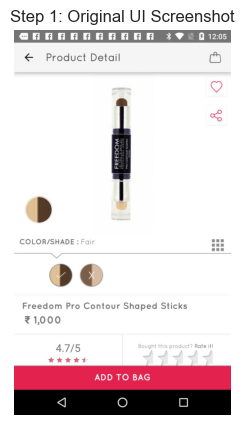

In [2]:
# Step 1: Load original UI screenshot
orig_img = Image.open(screenshot_path).convert('RGB')
orig_arr = np.array(orig_img)

plt.figure(figsize=(5, 5))
plt.imshow(orig_arr)
plt.title("Step 1: Original UI Screenshot")
plt.axis('off')
plt.show()

In [3]:
# Step 2: Generate saliency map using Grad-CAM
model = models.resnet50(pretrained=True)
grad_cam = GradCAM(model, "layer4")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

input_tensor = transform(orig_img).unsqueeze(0)
saliency = grad_cam(input_tensor)
saliency_resized = cv2.resize((saliency * 255).astype(np.uint8), orig_img.size)

c:\users\glibb\appdata\local\programs\python\python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\users\glibb\appdata\local\programs\python\python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\users\glibb\appdata\local\programs\python\python39\lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use regi

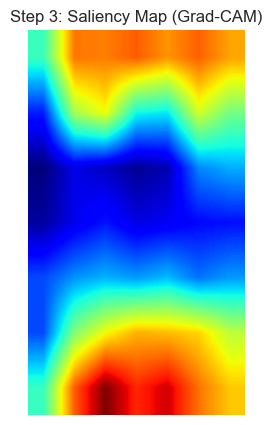

In [4]:
# Step 3: Show saliency map
plt.figure(figsize=(5, 5))
plt.imshow(saliency_resized, cmap='jet')
plt.title("Step 3: Saliency Map (Grad-CAM)")
plt.axis('off')
plt.show()

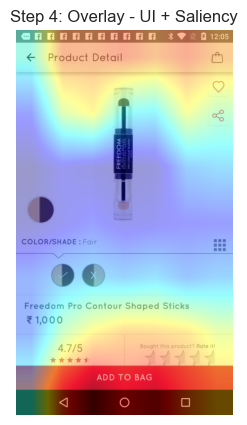

In [5]:
# Step 4: Overlay saliency on original image
def overlay_saliency_on_image(image, saliency_map):
    heatmap = cv2.applyColorMap(cv2.normalize(saliency_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(np.array(image), 0.6, heatmap_rgb, 0.4, 0)
    return overlay

overlay = overlay_saliency_on_image(orig_img, saliency_resized)

plt.figure(figsize=(5, 5))
plt.imshow(overlay)
plt.title("Step 4: Overlay - UI + Saliency")
plt.axis('off')
plt.show()

In [6]:
# Step 5: Compute metrics
attn = compute_attention_metrics(saliency_resized)
struct = compute_structure_metrics(np.array(orig_img))
placement = compute_average_placement_score(np.array(orig_img), saliency_resized)
score = compute_usability_score(attn, struct, placement)

Detected 2 saliency clusters above threshold 153


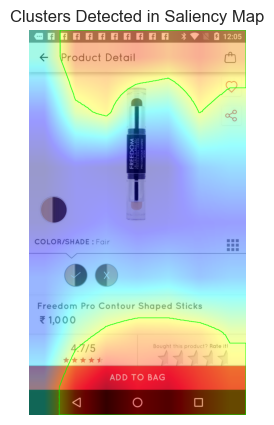

In [7]:
# Visualize attention clusters using binary threshold and contours
cluster_overlay = overlay.copy()
threshold_val = int(0.6 * np.max(saliency_resized))
_, binary_mask = cv2.threshold(saliency_resized, threshold_val, 255, cv2.THRESH_BINARY)
binary_mask = binary_mask.astype(np.uint8)
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    cv2.drawContours(cluster_overlay, [cnt], -1, (0, 255, 0), 2)

print(f"Detected {len(contours)} saliency clusters above threshold {threshold_val}")

plt.figure(figsize=(5, 5))
plt.imshow(cluster_overlay)
plt.title("Clusters Detected in Saliency Map")
plt.axis('off')
plt.show()

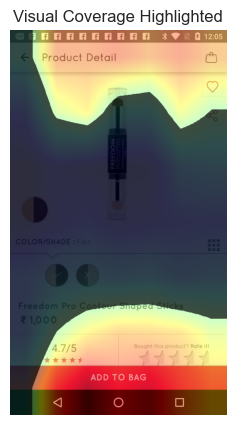

In [8]:
# Visualize coverage (saliency threshold region)
coverage_mask = saliency_resized > 128
coverage_img = overlay.copy()
coverage_img[~coverage_mask] = (coverage_img[~coverage_mask] * 0.3).astype(np.uint8)

plt.figure(figsize=(5, 5))
plt.imshow(coverage_img)
plt.title("Visual Coverage Highlighted")
plt.axis('off')
plt.show()

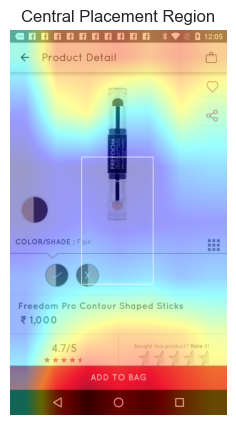

In [9]:
# Visualize placement - center box
placement_img = overlay.copy()
h, w = saliency_resized.shape
cx1, cx2 = int(0.33 * w), int(0.66 * w)
cy1, cy2 = int(0.33 * h), int(0.66 * h)
cv2.rectangle(placement_img, (cx1, cy1), (cx2, cy2), (255, 255, 255), 2)

plt.figure(figsize=(5, 5))
plt.imshow(placement_img)
plt.title("Central Placement Region")
plt.axis('off')
plt.show()

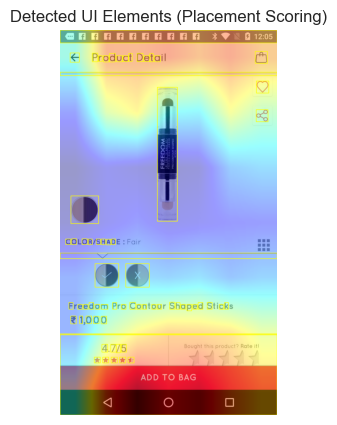

In [10]:
# Visualize UI element bounding boxes used in placement score
ui_overlay = overlay.copy()
bboxes = extract_ui_elements(np.array(orig_img))
for (x, y, bw, bh) in bboxes:
    cv2.rectangle(ui_overlay, (x, y), (x + bw, y + bh), (255, 255, 0), 2)

plt.figure(figsize=(5, 5))
plt.imshow(ui_overlay)
plt.title("Detected UI Elements (Placement Scoring)")
plt.axis('off')
plt.show()

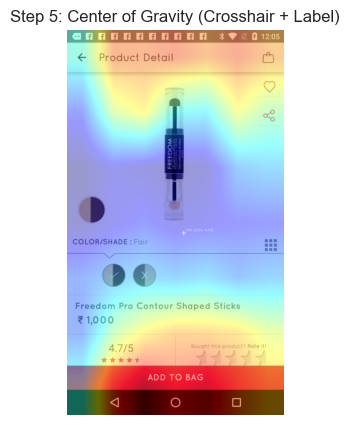

In [11]:
# Visualize bounding box around Center of Gravity
cog_x = attn['center_of_gravity_x']
cog_y = attn['center_of_gravity_y']
bbox_center = (int(cog_x * w), int(cog_y * h))

overlay_cog = overlay.copy()
cog_color = (255, 255, 255)
cv2.drawMarker(overlay_cog, bbox_center, cog_color, markerType=cv2.MARKER_CROSS, markerSize=20, thickness=2)
cv2.putText(overlay_cog, f'COG ({cog_x:.2f}, {cog_y:.2f})', (bbox_center[0]+10, bbox_center[1]-10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, cog_color, 1)

plt.figure(figsize=(5, 5))
plt.imshow(overlay_cog)
plt.title("Step 5: Center of Gravity (Crosshair + Label)")
plt.axis('off')
plt.show()

In [12]:
# Step 6: Display metrics
import pandas as pd
meta_path = "../data/uicrit/uicrit_public.csv"
meta_df = pd.read_csv(meta_path)

# Get filename without extension for RICO ID
import os
rico_id = int(os.path.splitext(os.path.basename(screenshot_path))[0])

# Filter rows for this screenshot
screenshot_ratings = meta_df[meta_df["rico_id"] == rico_id]["usability_rating"]

# Show all ratings and their average
print("--- UICrit Usability Ratings ---")
print("All Ratings:", list(screenshot_ratings))
print("Average UICrit Rating:", round(screenshot_ratings.mean(), 3))
print("\n--- Metric Breakdown ---")
print(f"Entropy: {attn['entropy']:.3f}")
print(f"Clusters: {attn['num_clusters']}")
print(f"Center of Gravity: ({attn['center_of_gravity_x']:.3f}, {attn['center_of_gravity_y']:.3f})")
print(f"Symmetry Score: {struct['symmetry_score']:.3f}")
print(f"Visual Coverage: {struct['visual_coverage']:.3f}")
print(f"Placement Score: {placement:.3f}")
print(f"\n🧮 Predicted Usability Score (0–1): {score:.3f}")

--- UICrit Usability Ratings ---
All Ratings: [6, 6, 8]
Average UICrit Rating: 6.667

--- Metric Breakdown ---
Entropy: 7.823
Clusters: 2
Center of Gravity: (0.539, 0.527)
Symmetry Score: 0.957
Visual Coverage: 0.234
Placement Score: 0.014

🧮 Predicted Usability Score (0–1): 1.066
